In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Neural Network with One-Hot Encoded NAICS
Traditional, simple neural network model with one hot encoded NAICS features

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.metrics as km

In [6]:
from sba_gnn.sba_gnn import sg_plot 

## Input Data

In [7]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('10_DATA_combined_scaled_all.parquet'))

In [8]:
business_data.columns

Index(['dset', 'LoanNr_ChkDgt', 'target', 'dset_naics_holdout', 'NAICS_orig',
       'NAICS_sector', 'menc_NAICS', 'cenc_NAICS', 'menc_grp_NAICS',
       'NAICS_alt_orig', 'NS___Accommodation and Food Services',
       'NS___Construction', 'NS___Health Care and Social Assistance',
       'NS___Manufacturing',
       'NS___Other Services (except Public Administration)',
       'NS___Professional, Scientific, and Technical Services',
       'NS___Retail Trade', 'NS___Wholesale Trade', 'NS___infrequent_sklearn',
       'NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business',
       'urban_flag', 'franchise_flag', 'missingindicator_LowDoc',
       'missingindicator_new_business', 'missingindicator_urban_flag', 'NAICS',
       'NAICS_alt'],
      dtype='object')

In [9]:
with open(Path(setup.temp_path).joinpath('10_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [10]:
naics_features = [c for c in business_data.columns if c.startswith('NS___')]

In [11]:
features = [f for f in imputer_features if 'NAICS' not in f] + naics_features
print(features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag', 'NS___Accommodation and Food Services', 'NS___Construction', 'NS___Health Care and Social Assistance', 'NS___Manufacturing', 'NS___Other Services (except Public Administration)', 'NS___Professional, Scientific, and Technical Services', 'NS___Retail Trade', 'NS___Wholesale Trade', 'NS___infrequent_sklearn']


##### Datasets for train, validation

In [12]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + features].set_index('LoanNr_ChkDgt').sort_index()

In [13]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (425594, 19), y:(425594,)


In [14]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (126041, 19), y:(126041,)


In [15]:
base_thresh = y_train.mean()
print(base_thresh)

0.20307382152943884


## Function to create model

In [16]:
def create_model(n_feat = len(features), 
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout):
    
    n_layers = len(hidden_size)
    model = Sequential()
    model.add(Dense(hidden_size[0], input_shape=(n_feat,), activation=activation))
    for i in range(1, n_layers):
        model.add(Dropout(dropout))
        model.add(Dense(hidden_size[i], input_shape=(hidden_size[i-1],), activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [17]:
this_model = create_model()

2024-02-24 06:39:25.365904: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-24 06:39:25.365930: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-24 06:39:25.365937: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-24 06:39:25.365983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-24 06:39:25.366003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
this_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2560      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10881 (42.50 KB)
Trainable params: 10881 (42.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
this_history = this_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-02-24 06:39:26.025462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 [==============================] - ETA: 0s - loss: 0.4710 - auc: 0.3106 - auc_1: 0.6792

2024-02-24 06:43:33.468193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 [==============================] - 292s 22ms/step - loss: 0.4710 - auc: 0.3106 - auc_1: 0.6792 - val_loss: 0.4658 - val_auc: 0.3372 - val_auc_1: 0.6995
Epoch 2/20
13300/13300 [==============================] - 288s 22ms/step - loss: 0.4634 - auc: 0.3295 - auc_1: 0.6957 - val_loss: 0.4630 - val_auc: 0.3442 - val_auc_1: 0.7053
Epoch 3/20
13300/13300 [==============================] - 220s 17ms/step - loss: 0.4620 - auc: 0.3341 - auc_1: 0.6993 - val_loss: 0.4619 - val_auc: 0.3470 - val_auc_1: 0.7071
Epoch 4/20
13300/13300 [==============================] - 192s 14ms/step - loss: 0.4613 - auc: 0.3364 - auc_1: 0.7007 - val_loss: 0.4613 - val_auc: 0.3485 - val_auc_1: 0.7073
Epoch 5/20
13300/13300 [==============================] - 191s 14ms/step - loss: 0.4607 - auc: 0.3393 - auc_1: 0.7022 - val_loss: 0.4608 - val_auc: 0.3502 - val_auc_1: 0.7089
Epoch 6/20
13300/13300 [==============================] - 320s 24ms/step - loss: 0.4606 - auc: 0.3383 - auc_1: 0.7027 - val_loss: 0.4607

In [20]:
this_history_df = pd.DataFrame(this_history.history)

In [21]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [22]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [23]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('14_REPORT_fit_history.csv'))

<Axes: >

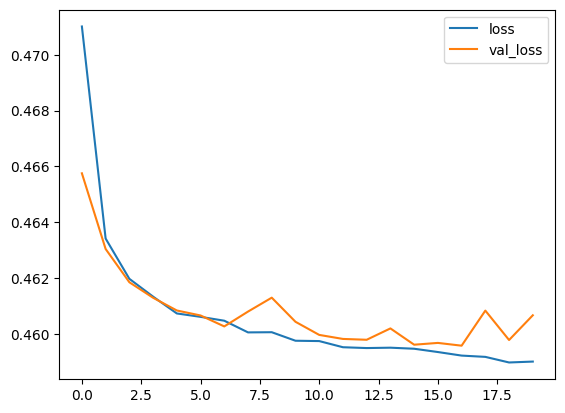

In [24]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

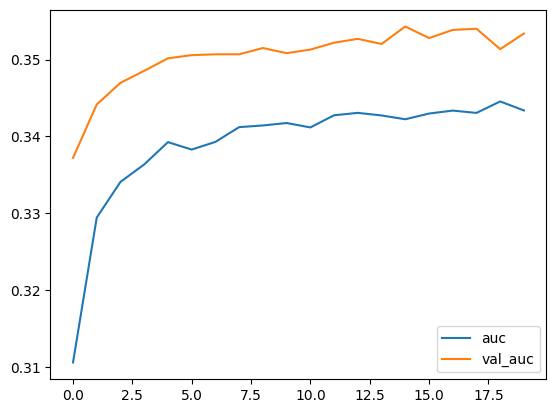

In [25]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

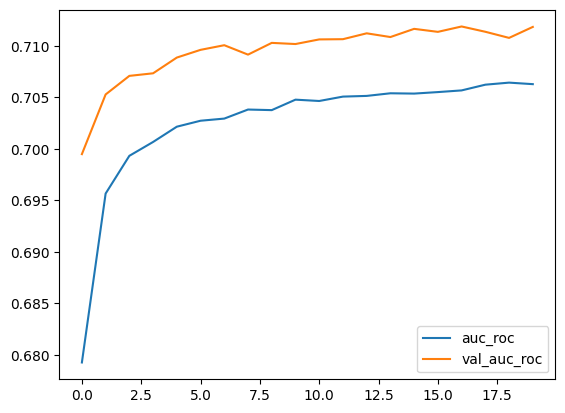

In [26]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [27]:
this_model.save(Path(setup.temp_path).joinpath('14_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [28]:
all_predictions = this_model.predict(X.drop(columns='dset'))

  111/21503 [..............................] - ETA: 29s

2024-02-24 09:14:26.813847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 28s 1ms/step


In [29]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(business_data[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout']], on='LoanNr_ChkDgt')
    

In [30]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.295448
target,0.295448,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [31]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [32]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [33]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
12,0.24,0.436233
13,0.26,0.435170
11,0.22,0.433991


In [34]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.24

##### Append binary predictions to probability predictions

In [35]:
all_predictions_df['predict_bin'] = sg_plot.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [36]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.514515
1    0.485485
Name: proportion, dtype: float64

In [37]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('14_DATA_predictions.parquet'))

## Metrics

In [38]:
all_predictions_df = pd.read_parquet(Path(setup.temp_path).joinpath('14_DATA_predictions.parquet'))

In [39]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('14_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.614360,0.434247,0.307610,0.738112,0.351912,0.713423,NaN
1,train,0.611092,0.436233,0.309113,0.740937,0.352198,0.711617,NaN
2,val,0.612531,0.439576,0.312748,0.739441,0.353450,0.711894,NaN
0,test,0.611724,0.438092,0.310621,0.743003,0.354201,0.712272,0.0
1,test,0.622520,0.421648,0.297785,0.721934,0.345082,0.716660,1.0
